<div align='center'>
  Pontifícia Universidade Católica de Minas Gerais</br>
  Programa de Pós-Graduação em Ciência de Dados e Big Data</br>
  Visualização de Dados
</div>
</br>

<div align='center'>
  <h1><b>ANÁLISE DE DADOS DO PRIMEIRO SPLIT DO CBLOL 2021</b></h1>
</div>
</br>

<div align='right'>
  ALUNO: Marco Túlio Barbosa Andrade</br>
  PROFESSOR: Felipe Lodur
</div>
</br>

<div align='center'>
  Belo Horizonte</br>
  2021
</div>

# Introdução

---

O presente trabalho tem como objetivo analisar informações diversas sobre o primeiro split do Campeonato Brasileiro de League of Legends (CBLoL) de 2021. Para isso, foram compostas e analisadas dez diferentes visualizações que abordam diversos aspectos dos jogos, times e jogadores da temporada.
</br></br>
Como fonte de dados principal, foi utilizada uma base de partidas competitivas disponiblizada na plataforma Kaggle (ver subseção *Importação dos dados*) que contém informações sobre a fase de escolhas, estatísticas dos jogos e resultados. Além disso, também foi criada e empregada uma base secundária a partir dos dados disponibilizados na página Leaguepedia (ver subseção *Importação dos dados*), uma vez que a primeira não dispunha de todas as partidas necessárias para composição de determinadas visualizações.

### Instalação e importação das bibliotecas

In [ ]:
#@title
#@title
# Instalação e importação das bibliotecas

!pip install plotly==5.3.1

import numpy as np
import pandas as pd
import plotly as pl
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import missingno as msno

### Definição das paletas de cores

In [ ]:
#@title
#@title
# Definição das paletas de cores

palette       = ['#3366CC', '#DC3912', '#109618', '#FF9900', '#990099', '#0099C6', '#DD4477', '#66AA00', '#8C564B', '#7F7F7F']
light_palette = ['#7194DB', '#E7755A', '#58B65E', '#FFB84D', '#B84DB8', '#4DB8D7', '#E77CA0', '#94C44D', '#AF8981', '#A6A6A6']

### Importação dos dados

In [ ]:
#@title
#@title
# Importação dos dados

# Fontes: https://www.kaggle.com/barthetur/lol-2021-competitive-game-from-012021-to-msi
#         https://lol.fandom.com/wiki/CBLOL/2021_Season/Split_1#

from google.colab import drive
drive.mount('/gdrive')

df = pd.read_csv('/gdrive/MyDrive/Colab Notebooks/Visualização de Dados/LoL_Split_1_2021_P1.csv', sep=';')

cblol = df.loc[df.league == 'CBLOL']

cblol2 = pd.read_csv('/gdrive/MyDrive/Colab Notebooks/Visualização de Dados/LoL_Split_1_2021_P2.csv', sep=',')

Mounted at /gdrive


### Análise de dados faltantes

Como demonstrado pelas visualizações de dados a seguir, ambas bases de dados não apresentam dados faltantes.

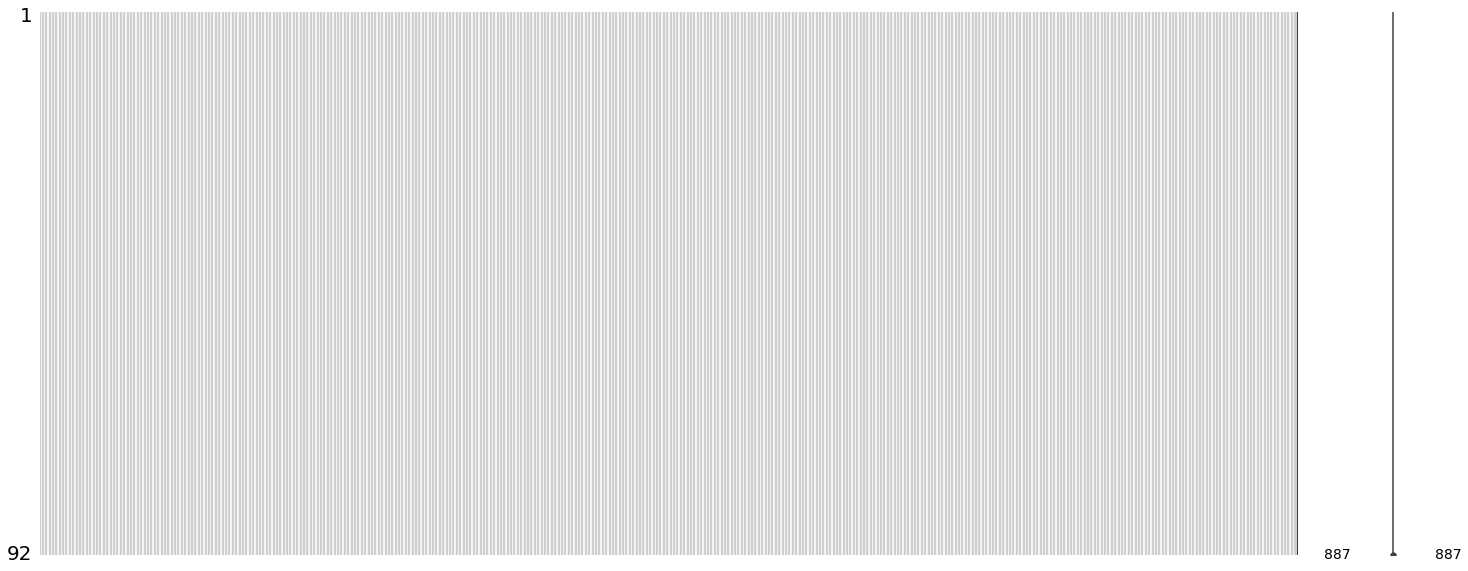

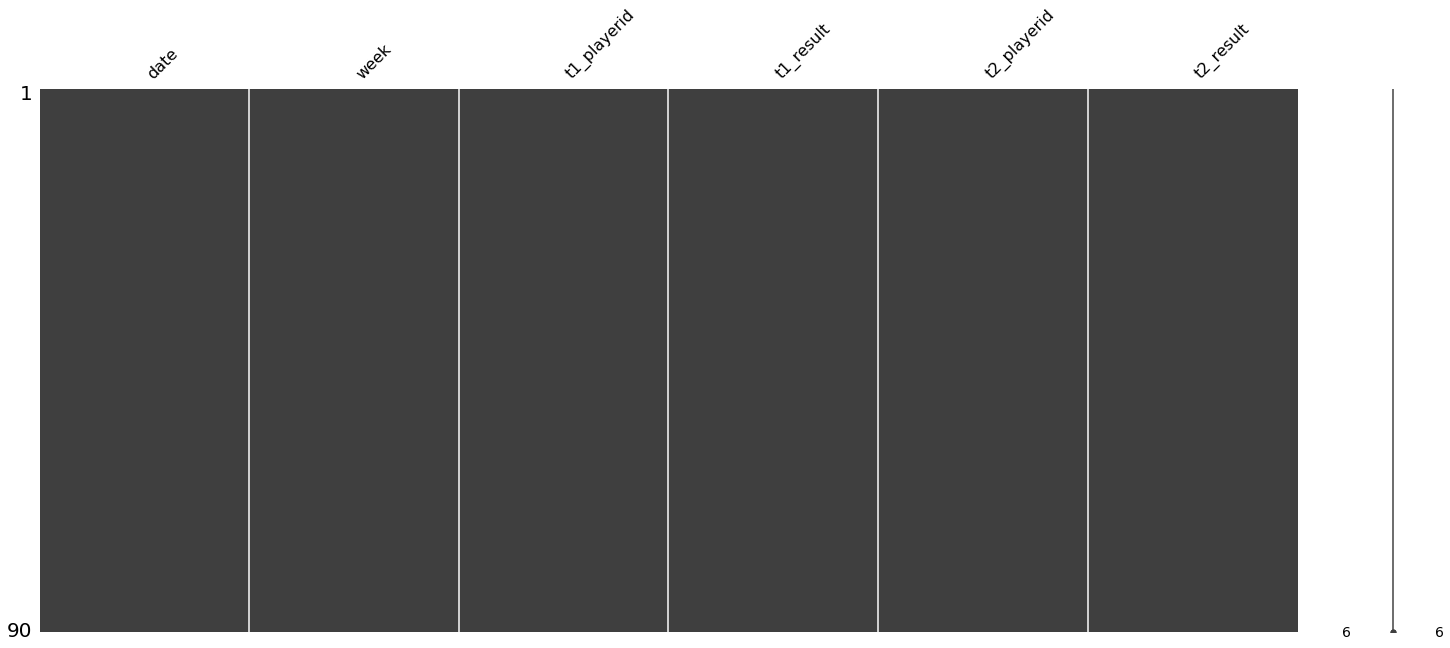

In [ ]:
#@title
#@title
# Análise de dados faltantes

msno.matrix(cblol)

msno.matrix(cblol2)

# Visualização I - Fase Regular

---



### Motivação

Como foi a trajetória dos times durante a fase regular?

### Preparação dos dados

In [ ]:
#@title
#@title
#===============================================================================
# Visualização I - Fase Regular
#===============================================================================

#-------------------------------------------------------------------------------
# Preparação dos dados
#-------------------------------------------------------------------------------

t1_result = cblol2[['date', 'week', 't1_playerid', 't1_result']]
t1_result.set_axis(['date', 'week', 'team', 'result'], axis=1, inplace=True)

t2_result = cblol2[['date', 'week', 't2_playerid', 't2_result']]
t2_result.set_axis(['date', 'week', 'team', 'result'], axis=1, inplace=True)

result = t1_result.append(t2_result)
result['date'] = result['date'].apply(lambda x: x[0:10])
result.sort_values(by='date', inplace=True)

bump_weekly = {}
bump_cumulative = {}

for team in result['team'].unique():
    bump_weekly.update({team: []})
    bump_cumulative.update({team: []})

for week in range(1, 10):
    for team in result['team'].unique():
        bump_weekly[team].append(result.loc[(result['week'] == f'Week {week}') & (result['team'] == team)]['result'].sum())
        
        if week != 1:
            bump_cumulative[team].append(bump_cumulative[team][week-2] + bump_weekly[team][week-1])
        else:
            bump_cumulative[team].append(bump_weekly[team][week-1])

result_df = pd.DataFrame(bump_cumulative).T
result_df.set_axis(['week1_win', 'week2_win', 'week3_win', 'week4_win', 'week5_win', 'week6_win', 'week7_win', 'week8_win', 'week9_win'], axis=1, inplace=True)

for i in range(len(result_df.columns)):
    wins_week = sorted(result_df[f'week{i+1}_win'], reverse=True)
    result_df.insert(len(result_df.columns), f'week{i+1}_rank', list(map(lambda x: wins_week.index(x)+1, result_df[f'week{i+1}_win'])))


result_df.insert(len(result_df.columns), 'team', list(result_df.index))
result_df.insert(len(result_df.columns), 'team_upper', list(map(lambda x: x.upper(), result_df.index)))
result_df.sort_values(by='team_upper', ascending=True, inplace=True)

### Visualização dos dados

In [ ]:
#@title
#===============================================================================
# Visualização I - Fase Regular
#===============================================================================

#-------------------------------------------------------------------------------
# Visualização dos dados
#-------------------------------------------------------------------------------

fig = go.Figure()

for team in result_df['team']:
    
    fig.add_trace(
        go.Scatter(
            x            = list(range(1, 10)),
            y            = result_df.loc[result_df['team'] == team, 'week1_rank':'week9_rank'].values[0],
            mode         = 'lines+markers',
            line_shape   = 'linear',
            line         = {
                'width': 2.5},
            marker       = {
                'size': 10},
            name         = team,
            text         = team,
            legendgroup  = 'grupo_' + team
        )
    )

fig.update_layout(
    title            = 'O SOBE E DESCE DA TABELA<br><sup><i>Posição dos times ao longo da fase regular</i></sup>',
    title_font_color = 'gray',
    title_font_size  = 20,
    colorway         = light_palette,
    width            = 1000,
    height           = 500,
    margin           = {'l': 125, 't': 125, 'b': 25},
    plot_bgcolor     = 'white',
    font_color       = 'gray',
    xaxis1           = {
        'title': 'Semana',
        'gridcolor': 'lightgray',
        'range': [.75, 9.25],
        'tickmode': 'array',
        'tickvals': list(range(1, 10))},
    yaxis1           = {
        'title': 'Posição',
        'gridcolor': 'whitesmoke',
        'gridwidth': 15,
        'range': [11, 0],
        'tickmode': 'array',
        'ticksuffix': '°',
        'tickvals': list(range(1, 11))}
)

fig.show()

### Análise

Como visto no gráfico, os times apresentaram comportamentos bastante diferenciados ao longo da fase regular. Enquanto algumas equipes se mostraram consideravelmente estáveis em suas colocações, variando em até 3 lugares, como a INTZ, a Pain e a RED, outras exibiram trajetória com grandes oscilações, tanto negativa, como a Rensga e a Fúria, como positivamente, vide Vorax. Ponto de destaque deve ser dado ao Flamengo, que ocupou a primeira colocação durante toda a fase regular.

# Visualização II - Playoffs

---



### Motivação

Como foi a trajetória dos times durante a fase de playoffs?

### Preparação e visualização dos dados

In [ ]:
#@title
#===============================================================================
# Visualização II - Playoffs
#===============================================================================

#-------------------------------------------------------------------------------
# Preparação e visualização dos dados
#-------------------------------------------------------------------------------

fig = go.Figure()

fig.add_trace(
    go.Sankey(
        arrangement= 'snap',
        node = {
            'thickness': 25,
            'pad': 25,
            'line': {
                'color': 'lightgray'},
            'label': ['Flamengo Esports',   #0
                      'Vorax',              #1
                      'RED Canids',         #2
                      'LOUD',               #3
                      'paiN Gaming',        #4
                      'KaBuM! e-Sports',    #5
                      'Quartas de Final 1', #6
                      'Quartas de Final 2', #7
                      'Semi-Final 1',       #8
                      'Semi-Final 2',       #9
                      'Final',              #10
                      'Campeão'],           #11
            'y': [.05, .20, .35, .50, .65, .80],
            'x': [.05, .05, .05, .05, .05, .05],
            'customdata': ['1° Lugar',
                           '2° Lugar',
                           '3° Lugar',
                           '4° Lugar',
                           '5° Lugar',
                           '6° Lugar',
                           'LOUD: 2</br>paiN Gaming: 3',
                           'RED Canids: 3</br>KaBuM! e-Sports: 1',
                           'Flamengo Esports: 2</br>paiN Gaming: 3',
                           'Vorax: 3</br>RED Canids: 1',
                           'paiN Gaming: 3</br>Vorax: 1',
                           'paiN Gaming'],
            'hovertemplate': '<b>%{label}</b><br>' +
                             '%{customdata}' +
                             '<extra></extra>',
            'color': "lightgray"},
        link = {
            'source': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
            'target': [8, 9, 7, 6, 6, 7, 8, 9, 10, 10, 11],
            'value':  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],      #'value':  [2, 3, 3, 2, 3, 1, 3, 1, 3, 1, 3],
            'color':  [*light_palette[0:6], light_palette[4], light_palette[2], light_palette[4], light_palette[1], light_palette[4]],
            'label':  ['Flamengo Esports', 'Vorax', 'RED Canids', 'LOUD', 'paiN Gaming', 'KaBuM! e-Sports',
                       'paiN Gaming', 'RED Canids', 'paiN Gaming', 'Vorax', 'paiN Gaming'],
            'hovertemplate': '%{label}<extra></extra>'}
    )
)

fig.update_layout(
    title            = 'NOS PLAYOFFS TUDO MUDA<br><sup><i>Resultados das chaves do campeonato</i></sup>',
    title_font_color = 'gray',
    title_font_size  = 20,
    colorway         = light_palette,
    width            = 1250,
    height           = 500,
    margin           = {'l': 50, 't': 125, 'b': 25},
    plot_bgcolor     = 'white',
    font_color       = 'gray'
)

fig.show()

### Análise

Apenas os 6 (seis) primeiros colocados avançaram para os playoffs. Os resultados das chaves demostram que a performance dos times em séries melhores de 5 (cinco) foi diferente daquela alcançada durante os jogos individuais da fase regular. Devido às suas colocações na tabela, o Flamengo e a Vorax tiveram lugar garantido diretamente nas semi-finais e, ainda assim, não foram campeões. Por outro lado, a Pain galgou seu caminho e se sagrou campeã mesmo tendo finalizado a fase de tabela na 5ª (quinta) colocação.

# Visualização III - Lado do mapa

---



### Motivação

Qual lado do mapa obteve a maior taxa de vitórias?

### Preparação dos dados

In [ ]:
#@title
#===============================================================================
# Visualização III - Lado do mapa
#===============================================================================

#-------------------------------------------------------------------------------
# Preparação dos dados
#-------------------------------------------------------------------------------

t1_wins = cblol['t1_result'].sum()
t2_wins = cblol['t2_result'].sum()

t1_wins_perc = t1_wins / len(cblol)
t2_wins_perc = t2_wins / len(cblol)

### Visualização dos dados

In [ ]:
#@title
#===============================================================================
# Visualização III - Lado do mapa
#===============================================================================

#-------------------------------------------------------------------------------
# Visualização dos dados
#-------------------------------------------------------------------------------

fig = make_subplots(
    rows = 1,
    cols = 2,
    specs=[[{'type': 'indicator'}, {'type': 'indicator'}]])

fig.add_trace(
    go.Indicator(
        mode   = 'gauge+number',
        value  = t1_wins_perc*100,
        number = {
            'suffix': '%',
            'font': {
                'size': 30,
                'color': light_palette[0]}},
        title  = {
            'text': 'Lado Azul',
            'font': {
                'size': 20,
                'color': 'darkgray'}},
        domain = {
            'x': [0, 1],
            'y': [0, 1]},
        gauge  = {
            'axis': {
                'range': [0, 100],
                'tickcolor': 'lightgray',
                'tickwidth': 2,
                'tickfont': {
                    'color':'gray'}},
            'bordercolor': 'lightgray',
            'borderwidth': 2,
            'bar': {
                'color': light_palette[0],
                'thickness': .75}}
    ),
    row = 1,
    col = 1
)

fig.add_trace(
    go.Indicator(
        mode   = 'gauge+number',
        value  = t2_wins_perc*100,
        number = {
            'suffix': '%',
            'font': {
                'size': 30,
                'color': light_palette[1]}},
        title  = {
            'text': 'Lado Vermelho',
            'font': {
                'size': 20,
                'color': 'darkgray'}},
        domain = {
            'x': [0, 1],
            'y': [0, 1]},
        gauge  = {
            'axis': {
                'range': [0, 100],
                'tickcolor': 'lightgray',
                'tickwidth': 2,
                'tickfont': {
                    'color':'gray'}},
            'bordercolor': 'lightgray',
            'borderwidth': 2,
            'bar': {
                'color': light_palette[1],
                'thickness': .75}}
    ),
    row = 1,
    col = 2
)

fig.update_layout(
    title             = 'LADO DE CÁ OU LADO DE LÁ?<br><sup><i>Taxa de vitórias por lado do mapa</i></sup>',
    title_font_color  = 'gray',
    title_font_size   = 20,
    width             = 750,
    height            = 300,
    margin            = {'t': 125, 'b': 25})

fig.show()

### Análise

Nenhum lado do mapa demostrou influência expressiva nos resultados dos jogos. Ainda assim, o Lado Azul foi aquele com a maior taxa de vitórias durante o campeonato, atingindo a marca de 53.3%.

# Visualização IV - Tempo de partida

---



### Motivação

Qual foi a duração média das partidas?

### Preparação dos dados

In [ ]:
#@title
#===============================================================================
# Visualização IV - Tempo de partida
#===============================================================================

#-------------------------------------------------------------------------------
# Preparação dos dados
#-------------------------------------------------------------------------------

game_length = cblol['gamelength']/60

### Visualização dos dados

In [ ]:
#@title
#===============================================================================
# Visualização IV - Tempo de partida
#===============================================================================

#-------------------------------------------------------------------------------
# Visualização dos dados
#-------------------------------------------------------------------------------

fig = make_subplots(
    rows             = 2,
    cols             = 1,
    row_heights      = [0.25, 0.75],
    specs            = [[{'type': 'violin'}],
                        [{'type': 'histogram'}]],
    shared_xaxes     = True,
    vertical_spacing = 0.02
)

fig.add_trace(
    go.Violin(
        x      = game_length,
        y0     = ' ',
        marker = {
            'color': light_palette[2]}
    ),
    row = 1,
    col = 1
)

fig.add_trace(
    go.Histogram(
        x      = game_length,
        marker = {
            'color': light_palette[2]}
    ),
    row = 2,
    col = 1
)

fig.add_indicator(
    mode   = 'number',
    value  = game_length.mean(),
    title  = {
        'text': 'Duração Média',
        'font': {
            'color': 'gray',
            'size': 15}},
    number = {
        'suffix': 'min',
        'font': {
            'size': 15,
            'color': light_palette[2]}},
    domain = {
        'x': [0, .85],
        'y': [.15, 1]}
)

fig.add_shape(
    type  = 'line',
    line  = {
        'color': 'gray',
        'dash': 'dash'},
    x0    = 31.65,   x1 = 31.65,
    y0    = 0,       y1 = 1,
    xref  = 'x2',
    yref  = 'paper'
)

fig.update_layout(
    title             = 'VAMOS FINALIZAR A PARTIDA OU NÃO?<br><sup><i>Distribuição dos tempos de partida</i></sup>',
    title_font_color  = 'gray',
    title_font_size   = 20,
    width             = 1000,
    height            = 400,
    margin            = {'l': 125, 'b': 25},
    bargap            = 0.2,
    plot_bgcolor      = 'whitesmoke',
    font_color        = 'gray',
    showlegend        = False,
    xaxis2 =  {
        'title': "Tempo (min)",
        'showgrid': True},
    yaxis2 =  {
        'title': "Frequência",
        'showgrid': True,
        'range': [0, 30]}
)


fig.show()

### Análise

O tempo média de partida durante o campeonato foi de 31.65 minutos, com aproximadamente 50% dos jogos durado entre 28 e 34 minutos. Partidas mais curtas que 25 minutos e mais longas que 45 minutos foram raras.

# Visualização V - Picks e bans

---



### Motivação

Quais foram os campeões mais escolhidos, banidos e relevantes durante o campeonato?

### Preparação dos dados

In [ ]:
#@title
#===============================================================================
# Visualização V - Picks e bans
#===============================================================================

#-------------------------------------------------------------------------------
# Preparação dos dados
#-------------------------------------------------------------------------------

t1_picks = [*cblol['t1p1_champion'], *cblol['t1p2_champion'], *cblol['t1p3_champion'], *cblol['t1p4_champion'], *cblol['t1p5_champion']]
t2_picks = [*cblol['t2p1_champion'], *cblol['t2p2_champion'], *cblol['t2p3_champion'], *cblol['t2p4_champion'], *cblol['t2p5_champion']]
picks    = [*t1_picks, *t2_picks]
df_picks = pd.DataFrame(picks)

t1_bans = [*cblol['t1_ban1'], *cblol['t1_ban2'], *cblol['t1_ban3'], *cblol['t1_ban4'], *cblol['t1_ban5']]
t2_bans = [*cblol['t2_ban1'], *cblol['t2_ban2'], *cblol['t2_ban3'], *cblol['t2_ban4'], *cblol['t2_ban5']]
bans    = [*t1_bans, *t2_bans]
df_bans = pd.DataFrame(bans)

picks_bans    = [*picks, *bans]
df_picks_bans = pd.DataFrame(picks_bans)

df_top3 = [df_picks.value_counts()[0:3],
           df_bans.value_counts()[0:3],
           df_picks_bans.value_counts()[0:3]]

NameError: ignored

### Visualização dos dados

In [ ]:
#@title
#===============================================================================
# Visualização V - Picks e bans
#===============================================================================

#-------------------------------------------------------------------------------
# Visualização dos dados
#-------------------------------------------------------------------------------

top3_titles    = ['Escolhidos', 'Banidos', 'Relevantes']
top3_subtitles = ['pick', 'ban', 'pick + ban']

for i in range (0, 3):

    fig = make_subplots(
        rows  = 1,
        cols  = 3,
        specs = [[{'type': 'pie'}, {'type': 'pie'}, {'type': 'pie'}]]
    )

    for j in range (0, 3):

        fig.add_trace(
            go.Sunburst(
                labels                = [' ', df_top3[i].index[j], None],
                parents               = [None, ' ', ' '],
                values                = [len(cblol), df_top3[i][j]],
                branchvalues          = 'total',
                insidetextorientation = 'horizontal',
                hovertemplate         ='<b>%{label}</b><br> N° de Partidas: %{value}',
                marker                = {
                    'colors': [None, palette[i]]}
            ),
            row = 1,
            col = j+1
        )

        fig.add_trace(
            go.Indicator(
                mode   = 'number',
                value  = df_top3[i][j] * 100 / len(cblol),
                number = {
                    'suffix': '%',
                    'font': {
                        'size': 15,
                        'color': light_palette[i]}},
                domain = {
                    'x': [0, 1],
                    'y': [0, 1]}
            ),
            row = 1,
            col = j+1
        )

    fig.update_layout(
        title             = 'SÓ OS BONECÕES - MAIS ' + top3_titles[i].upper() + '<br><sup><i>Taxa de ' + top3_subtitles[i] + ' por campeão</i></sup>',
        title_font_color  = 'gray',
        title_font_size   = 20,
        width             = 800,
        height            = 300,
        margin            = {'b': 25},
        uniformtext       = {'minsize': 15, 'mode': 'hide'}
    )

    fig.show()

### Análise

Os campeões mais escolhidos foram Kai'Sa (atirador), Rell (suporte) e Alistar (suporte), indicando uma consistência dos campeões da rota inferior. Já os campeões mais banidos foram Camille (topo), Renekton (topo) e Olaf (caçador), demonstrando o poder dos lutadores da rota topo durante o split. Por fim, considerando as taxas de participação (escolhas mais banimentos), Camille, Kai'Sa e Udyr foram os campeões mais relevantes do campeonato. Os resultados apontam, portanto, a falta de prioridade que a rota do meio teve na fase de escolhas.

# Visualização VI - Ouro e experiência

---



### Motivação

Como foi o início de jogo dos times e como transitaram para o meio de partida em termos de recursos?

### Preparação dos dados

In [ ]:
#===============================================================================
# Visualização VI - Ouro e experiência
#===============================================================================

#-------------------------------------------------------------------------------
# Preparação dos dados
#-------------------------------------------------------------------------------

t1_diff = cblol[['t1_playerid', 't1_golddiffat10', 't1_golddiffat15', 't1_xpdiffat10', 't1_xpdiffat15']]
t1_diff.set_axis(['team', 'golddiffat10', 'golddiffat15', 'xpdiffat10', 'xpdiffat15'], axis=1, inplace=True)

t2_diff = cblol[['t2_playerid', 't2_golddiffat20', 't2_golddiffat25', 't2_xpdiffat20', 't2_xpdiffat25']]
t2_diff.set_axis(['team', 'golddiffat10', 'golddiffat15', 'xpdiffat10', 'xpdiffat15'], axis=1, inplace=True)

diff = t1_diff.append(t2_diff)

mean_diff = diff.groupby('team').mean()
mean_diff.insert(4, 'team', list(mean_diff.index))
mean_diff.insert(5, 'team_upper', list(map(lambda x: x.upper(), mean_diff.index)))
mean_diff.sort_values(by='team_upper', ascending=True, inplace=True)

### Visualização dos dados

In [ ]:
#@title
#===============================================================================
# Visualização VI - Ouro e experiência
#===============================================================================

#-------------------------------------------------------------------------------
# Visualização dos dados
#-------------------------------------------------------------------------------

fig = make_subplots(
    rows             = 1,
    cols             = 2,
    specs            = [[{'type': 'scatter'}, {'type': 'scatter'}]],
    horizontal_spacing = 0.15
)

for team in mean_diff['team']:
    
    fig.add_trace(
        go.Scatter(
            x            = [0, 1],
            y            = [*mean_diff.loc[mean_diff['team'] == team]['golddiffat10'], *mean_diff.loc[mean_diff['team'] == team]['golddiffat15']],
            mode         = 'lines+markers',
            line         = {
                'width': 2.5},
            marker       = {
                'size': 10},
            name         = team,
            text         = team,
            legendgroup  = 'grupo_' + team
        ),
        row = 1,
        col = 1
    )

for team in mean_diff['team']:
    
    fig.add_trace(
        go.Scatter(
            x            = [0, 1],
            y            = [*mean_diff.loc[mean_diff['team'] == team]['xpdiffat10'], *mean_diff.loc[mean_diff['team'] == team]['xpdiffat15']],
            mode         = 'lines+markers',
            line         = {
                'width': 2.5},
            marker       = {
                'size': 10},
            name         = team,
            text         = team,
            legendgroup  = 'grupo_' + team,
            showlegend   = False
        ),
        row = 1,
        col = 2
    )

fig.add_shape(
    type  = 'line',
    line  = {
        'color': 'gray'},
    x0    = 0,   x1 = 0,
    y0    = 0,   y1 = 1,
    xref  = 'x1',
    yref  = 'paper'
)

fig.add_annotation(
    text      = 'Diferença de ouro<br>aos 10min',
    font      = {
        'color': 'gray'},
    showarrow = False,
    x         = 0,
    y         = 1.15,
    xref      = 'x1',
    yref      = 'paper'
)

fig.add_shape(
    type  = 'line',
    line  = {
        'color': 'gray'},
    x0    = 1,   x1 = 1,
    y0    = 0,   y1 = 1,
    xref  = 'x1',
    yref  = 'paper'
)

fig.add_annotation(
    text      = 'Diferença de ouro<br>aos 15min',
    font      = {
        'color': 'gray'},
    showarrow = False,
    x         = 1,
    y         = 1.15,
    xref      = 'x1',
    yref      = 'paper'
)

fig.add_shape(
    type  = 'line',
    line  = {
        'color': 'gray',
        'dash': 'dash'},
    x0    = -.3,   x1 = 1.3,
    y0    = 0,   y1 = 0,
    xref  ='x1',
    yref  ='y1'
)

fig.add_shape(
    type  = 'line',
    line  = {
        'color': 'gray'},
    x0    = 0,   x1 = 0,
    y0    = 0,   y1 = 1,
    xref  = 'x2',
    yref  = 'paper'
)

fig.add_annotation(
    text      = 'Diferença de XP<br>aos 10min',
    font      = {
        'color': 'gray'},
    showarrow = False,
    x         = 0,
    y         = 1.15,
    xref      = 'x2',
    yref      = 'paper'
)

fig.add_shape(
    type  = 'line',
    line  = {
        'color': 'gray'},
    x0    = 1,   x1 = 1,
    y0    = 0,   y1 = 1,
    xref  = 'x2',
    yref  = 'paper'
)

fig.add_annotation(
    text      = 'Diferença de XP<br>aos 15min',
    font      = {
        'color': 'gray'},
    showarrow = False,
    x         = 1,
    y         = 1.15,
    xref      = 'x2',
    yref      = 'paper'
)

fig.add_shape(
    type  = 'line',
    line  = {
        'color': 'gray',
        'dash': 'dash'},
    x0    = -.3,   x1 = 1.3,
    y0    = 0,   y1 = 0,
    xref  ='x2',
    yref  ='y2'
)

fig.update_layout(
    title            = 'A FAMOSA TRANSIÇÃO DO EARLY PARA MID GAME<br><sup><i>Diferença de ouro e XP ao longo do tempo</i></sup>',
    title_font_color = 'gray',
    title_font_size  = 20,
    colorway         = light_palette,
    width            = 1000,
    height           = 500,
    margin           = {'l': 100, 'r': 200, 't': 175, 'b': 25},
    plot_bgcolor     = 'white',
    font_color       = 'gray',
    xaxis1           = {
        'showline': False,
        'showticklabels': False,
        'range': [-.05, 1.05]},
    xaxis2           = {
        'showline': False,
        'showticklabels': False,
        'range': [-.05, 1.05]},
    yaxis1           = {
        'showline': False,
        'showticklabels': True,
        'range': [-2250, 2250],
        'nticks': 5},
    yaxis2           = {
        'showline': False,
        'showticklabels': True,
        'range': [-1500, 1500],
        'nticks': 5}
)

fig.show()

### Análise

Ao analisar os gráficos de diferença de ouro e experiência aos 10 e 15 minutos, percebe-se que, em média, apenas 4 (quatro) times conseguiam construir vantagens no ínicio de partida, sendo eles a Pain, a Red, o Flamengo e a Vorax. Além disso, essas mesmas equipes, com exceção da Vorax em termos de ouro, eram, em geral, capazes de aumentar sua vantagem na transição do início para o meio de partida. Em direção oposta, a Loud, a Fúria e a Rensga, além de iniciarem atrás, ainda aumentavam sua desvantagem em recursos ao longo do tempo. Em patamar intermediário, encontravam-se a Kabum, a INTZ e o Cruzeiro que, apesar de iniciarem em posição um pouco atrás de seus oponentes, eram capazes de estagnar e/ou mitigar a desvantagem em experiência pelo menos.

# Visualização VII - Visão

---



### Motivação

Qual foi a relação do placar de visão e o desempenho dos times?

### Preparação dos dados

In [ ]:
#@title
#===============================================================================
# Visualização VII - Visão
#===============================================================================

#-------------------------------------------------------------------------------
# Preparação dos dados
#-------------------------------------------------------------------------------

t1_vision = cblol[['t1_playerid', 'gamelength', 't1_result', 't1_wardsplaced', 't1_wardskilled', 't1_controlwardsbought', 't1_visionscore']]
t1_vision.set_axis(['team', 'length', 'result', 'wardsplaced', 'wardskilled', 'controlwardsbought', 'visionscore'], axis=1, inplace=True)

t2_vision = cblol[['t2_playerid', 'gamelength', 't2_result', 't2_wardsplaced', 't2_wardskilled', 't2_controlwardsbought', 't2_visionscore']]
t2_vision.set_axis(['team', 'length', 'result', 'wardsplaced', 'wardskilled', 'controlwardsbought', 'visionscore'], axis=1, inplace=True)

team_vision = t1_vision.append(t2_vision)

team_vision.insert(len(team_vision.columns), 'duration', list(map(lambda x: x/60, team_vision['length'])))
team_vision.insert(len(team_vision.columns), 'wppm', list(map(lambda x, y: x/y, team_vision['wardsplaced'], team_vision['duration'])))
team_vision.insert(len(team_vision.columns), 'wkpm', list(map(lambda x, y: x/y, team_vision['wardskilled'], team_vision['duration'])))
team_vision.insert(len(team_vision.columns), 'cwbpm', list(map(lambda x, y: x/y, team_vision['controlwardsbought'], team_vision['duration'])))
team_vision.insert(len(team_vision.columns), 'vspm', list(map(lambda x, y: x/y, team_vision['visionscore'], team_vision['duration'])))

team_vision = team_vision.groupby(by='team').mean()

team_vision['wppm'] = team_vision['wppm'].map(lambda x: round(x, ndigits=2))
team_vision['wkpm'] = team_vision['wkpm'].map(lambda x: round(x, ndigits=2))
team_vision['cwbpm'] = team_vision['cwbpm'].map(lambda x: round(x, ndigits=2))
team_vision['vspm'] = team_vision['vspm'].map(lambda x: round(x, ndigits=2))
team_vision.insert(len(team_vision.columns), 'winrate', list(map(lambda x: round(100*x, ndigits=2), team_vision['result'])))

team_vision.insert(len(team_vision.columns), 'team', list(team_vision.index))
team_vision.insert(len(team_vision.columns), 'team_upper', list(map(lambda x: x.upper(), team_vision.index)))
team_vision.sort_values(by='vspm', ascending=True, inplace=True)

### Visualização dos dados

In [ ]:
#@title
#===============================================================================
# Visualização VII - Visão
#===============================================================================

#-------------------------------------------------------------------------------
# Visualização dos dados
#-------------------------------------------------------------------------------

fig = make_subplots(
    specs = [[{"secondary_y": True}]]
)

for i, ward in enumerate(['Sentinelas colocadas', 'Sentinelas destruídas', 'Sentinelas de controle<br>compradas']):
    
    fig.add_trace(
        go.Bar(
            x            = team_vision['team'],
            y            = team_vision.iloc[:, i+7],
            orientation  = 'v',
            name         = ward
        ),
        secondary_y = False
    )

fig.add_trace(
    go.Scatter(
        x            = team_vision['team'],
        y            = team_vision['vspm'],
        name         = 'Placar de visão'
    )
)

fig.add_trace(
    go.Scatter(
        x            = team_vision['team'],
        y            = team_vision['winrate'],
        name         = 'Taxa de vitórias'
    ),
    secondary_y = True
)

fig.update_layout(
    title            = 'ILUMINANDO O CAMINHO<br><sup><i>Média de sentinelas, placar de visão e taxa de vitória</i></sup>',
    title_font_color = 'gray',
    title_font_size  = 20,
    colorway         = light_palette,
    width            = 1250,
    height           = 500,
    margin           = {'l': 100, 't': 125, 'b': 25},
    plot_bgcolor     = 'white',
    font_color       = 'gray',
    xaxis1           = {
        'title': 'Times (ordenados por placar de visão)'},
    yaxis1           = {
        'title': 'Visão por minuto',
        'gridcolor': 'whitesmoke',
        'range': [0, 8.5]},
    yaxis2           = {
        'title': 'Taxa de vitória (%)',
        'gridcolor': 'whitesmoke',
        'range': [0, 85],
        'ticksuffix': '%'}
)

fig.show()

### Análise

Os números médios de sentinelas colocadas, destruídas e compradas (sentinelas de controle) por minuto foram bastante próximos entre os times, sendo necessária a visualização do placar de visão por minuto para conseguir distinguir um pouco suas nuances. Ainda assim, grande parte das equipes se encontraram na faixa de 7 a 8 pontos por minuto, com excessão do Cruzeiro e da Furia (abaixo) e da Kabum (acima). Ao confrontar o placar de visão com a taxa de vitórias das equipes, nota-se que seu comportamento não possui uma grande correlação. A Kabum, por exemplo, que se destacou em termos de visão, alcançou apenas uma taxa de vitória mediana (50%), enquanto a Vorax, que apresentou números de visão intermediários foi a líder em taxa de vitórias (68.75%).

# Visualização VIII - Objetivos

---



### Motivação

Qual foi a relação entre execução dos primeiros objetivos e a taxa de vitória?

### Preparação dos dados

In [ ]:
#@title
#===============================================================================
# Visualização VIII - Objetivos
#===============================================================================

#-------------------------------------------------------------------------------
# Preparação dos dados
#-------------------------------------------------------------------------------

t1_first_obj = cblol[['t1_playerid', 't1_result', 't1_firstblood', 't1_firstdragon', 't1_firstherald', 't1_firstbaron', 't1_firsttower']]
t1_first_obj.set_axis(['playerid', 'result', 'firstblood', 'firstdragon', 'firstherald', 'firstbaron', 'firsttower'], axis=1, inplace=True)

t2_first_obj = cblol[['t2_playerid', 't2_result', 't2_firstblood', 't2_firstdragon', 't2_firstherald', 't2_firstbaron', 't2_firsttower']]
t2_first_obj.set_axis(['playerid', 'result', 'firstblood', 'firstdragon', 'firstherald', 'firstbaron', 'firsttower'], axis=1, inplace=True)

first_obj = t1_first_obj.append(t2_first_obj)

obj_winrate = {}
obj_winrate.update({'First Blood':     round(100 * len(first_obj.loc[(first_obj['result'] == 1) & (first_obj['firstblood'] == 1)])  / len(first_obj.loc[first_obj['firstblood'] == 1]), ndigits=2)})
obj_winrate.update({'Primeiro Dragão': round(100 * len(first_obj.loc[(first_obj['result'] == 1) & (first_obj['firstdragon'] == 1)]) / len(first_obj.loc[first_obj['firstdragon'] == 1]), ndigits=2)})
obj_winrate.update({'Primeiro Arauto': round(100 * len(first_obj.loc[(first_obj['result'] == 1) & (first_obj['firstherald'] == 1)]) / len(first_obj.loc[first_obj['firstherald'] == 1]), ndigits=2)})
obj_winrate.update({'Primeiro Barão':  round(100 * len(first_obj.loc[(first_obj['result'] == 1) & (first_obj['firstbaron'] == 1)])  / len(first_obj.loc[first_obj['firstbaron'] == 1]), ndigits=2)})
obj_winrate.update({'Primeira Torre':  round(100 * len(first_obj.loc[(first_obj['result'] == 1) & (first_obj['firsttower'] == 1)])  / len(first_obj.loc[first_obj['firsttower'] == 1]), ndigits=2)})
obj_winrate = dict(sorted(obj_winrate.items(), key=lambda x: x[1]))

### Visualização dos dados

In [ ]:
#@title
#===============================================================================
# Visualização VIII - Objetivos
#===============================================================================

#-------------------------------------------------------------------------------
# Visualização dos dados
#-------------------------------------------------------------------------------

fig = go.Figure()

fig.add_trace(
    go.Bar(
        x           = list(obj_winrate.values()),
        y           = list(obj_winrate.keys()),
        orientation = 'h',
        marker      = {
            'color': light_palette[2]}
    )
)

annotations = []

winrate_round = np.round(list(obj_winrate.values()), decimals=2)

for wr, x in zip(winrate_round, list(obj_winrate.keys())):
    annotations.append({
        'xref': 'x1',
        'yref': 'y1',
        'y': x,
        'x': wr - 7.5,
        'text': str(wr) + '%',
        'font': {
            'color': 'white',
            'size': 15},
        'showarrow': False})

fig.update_layout(
    title            = 'FOCA O OBJETIVO!<br><sup><i>Taxa de vitórias por realização de objetivos</i></sup>',
    title_font_color = 'gray',
    title_font_size  = 20,
    width            = 750,
    height           = 400,
    margin           = {'l': 150, 'b': 25},
    plot_bgcolor      = 'whitesmoke',
    font_color       = 'gray',
    annotations      = annotations,
    xaxis1           = {
        'title': 'Taxa de Vitória (%)',
        'showgrid': True,
        'range': [0, 100]}
)

fig.show()

### Análise

Além do objetivo principal do jogo, que é a destruição do Nexus inimigo, a execução dos demais objetivos do jogo se mostrou extremamente importante na construção da vantagem de um time sobre o outro. Ainda que em diferentes proporções, as taxas de vitórias apresentadas pelo times que executaram os primeiros objetivos foram positivas para todos os tipos analisados. Começando pelo Dragão, que fica disponível no mapa no início do jogo e mostrou índice de 56.52% de vitórias, e terminando no Barão, que aparece somente aos 20 minutos de partida e alcançou o patamar extremamente elevado de 92.22% de vitórias, é possível delinear de modo geral uma progressão cíclica de vantagem, em que vantagens possibilitam objetos e estes geram mais vantagem.

# Visualização IX - Dano

---



### Motivação

Como foi a composição do dano dos times em termos de posição?

### Preparação dos dados

In [ ]:
#@title
#===============================================================================
# Visualização IX - Dano
#===============================================================================

#-------------------------------------------------------------------------------
# Preparação dos dados
#-------------------------------------------------------------------------------

t1_player_damage = cblol[['t1_playerid', 't1_damagetochampions', 't1p1_damagetochampions', 't1p2_damagetochampions', 't1p3_damagetochampions', 't1p4_damagetochampions', 't1p5_damagetochampions']]
t1_player_damage.set_axis(['team', 'total_dmg', 'p1_dmg', 'p2_dmg', 'p3_dmg', 'p4_dmg', 'p5_dmg'], axis=1, inplace=True)

t2_player_damage = cblol[['t2_playerid', 't2_damagetochampions', 't2p1_damagetochampions', 't2p2_damagetochampions', 't2p3_damagetochampions', 't2p4_damagetochampions', 't2p5_damagetochampions']]
t2_player_damage.set_axis(['team', 'total_dmg', 'p1_dmg', 'p2_dmg', 'p3_dmg', 'p4_dmg', 'p5_dmg'], axis=1, inplace=True)

player_damage = t1_player_damage.append(t2_player_damage)
team_damage = player_damage.groupby(by='team').sum()

for column in team_damage.columns:
    team_damage.insert(len(team_damage.columns), f'{column}_avg', list(map(lambda x, y: round(100 * x / y, ndigits=2), team_damage[column], team_damage['total_dmg'])))

team_damage.insert(len(team_damage.columns), 'team', list(team_damage.index))
team_damage.insert(len(team_damage.columns), 'team_upper', list(map(lambda x: x.upper(), team_damage.index)))
team_damage.sort_values(by='team_upper', ascending=False, inplace=True)

### Visualização dos dados

In [ ]:
#@title
#===============================================================================
# Visualização IX - Dano
#===============================================================================

#-------------------------------------------------------------------------------
# Visualização dos dados
#-------------------------------------------------------------------------------

fig = go.Figure()

for i, role in enumerate(['Topo', 'Caçador', 'Meio', 'Atirador', 'Suporte']):
    
    fig.add_trace(
        go.Bar(
            y            = team_damage['team'],
            x            = team_damage[f'p{i+1}_dmg_avg'],
            texttemplate = '%{x}%',
            textfont     = {
                'color': 'white'},
            orientation  = 'h',
            name         = role
        )
    )

fig.update_layout(
    title            = 'OLHA ESSE GRÁFICO DE DANO<br><sup><i>Composição média do dano por posição </i></sup>',
    title_font_color = 'gray',
    title_font_size  = 20,
    colorway         = light_palette,
    width            = 1000,
    height           = 500,
    margin           = {'l': 175, 't': 125, 'b': 25},
    plot_bgcolor     = 'white',
    font_color       = 'gray',
    barmode          = 'stack',
    legend           = {
        'traceorder': 'normal'},
    xaxis1           = {
        'title': 'Participação média (%)',
        'range': [0, 100]}
)

fig.show()

### Análise

Como esperado, observa-se que as posições de suporte e caçador foram as que apresentaram menores índices de danos em todas as equipes, uma vez que, em geral, têm como papéis principais o controle de visão, objetivos e direcionamento do jogo. Por outro lado, o topo, o meio e o atirador são posições que podem ser foco de recursos e, consequentemente, de dano. Nesse sentido, é possível dividir as equipes em grupos de acordo com seu foco e estilo de jogo. No Cruzeiro e na Red, o papel de causador principal de dano foi o atirador, enquanto no Flamengo, na Kabum, na Rensga e na Vorax essa função foi exercida principalmente pelo topo. Já na Furia, na INTZ, na Loud e na Pain, o meio foi a posição de destaque.

# Visualização X - KDA Player

---



### Motivação

Quais foram os jogadores com os melhores KDA's (relação de abates/mortes/assistências)?

### Preparação dos dados

In [ ]:
#@title
#===============================================================================
# Visualização X - KDA Player
#===============================================================================

#-------------------------------------------------------------------------------
# Preparação dos dados
#-------------------------------------------------------------------------------

kda = pd.DataFrame()

for i in range(1, 3):
    for j in range(1, 6):
        stats = cblol[[f't{i}_playerid', f't{i}p{j}_player', f't{i}p{j}_kills', f't{i}p{j}_deaths', f't{i}p{j}_assists']]
        stats.set_axis(['team', 'player', 'kills', 'deaths', 'assists'], axis=1, inplace=True)
        kda = kda.append(stats)

mean_kda = kda.groupby(by=['team', 'player']).mean()
mean_kda.insert(3, 'player', list(mean_kda.index.get_level_values(1)))
mean_kda.insert(4, 'team', list(mean_kda.index.get_level_values(0)))
mean_kda.insert(5, 'team_upper', list(map(lambda x: x.upper(), mean_kda.index.get_level_values(0))))

mean_kda['kills']   = np.round(mean_kda['kills'], decimals=2)
mean_kda['deaths']  = np.round(mean_kda['deaths'], decimals=2)
mean_kda['assists'] = np.round(mean_kda['assists'], decimals=2)
mean_kda['kda']     = np.round((mean_kda['kills'] + mean_kda['assists']) / mean_kda['deaths'], decimals=2)

mean_kda.sort_values(by='team_upper', ascending=True, inplace=True)

### Visualização dos dados

In [ ]:
#@title
#===============================================================================
# Visualização X - KDA Player
#===============================================================================

#-------------------------------------------------------------------------------
# Visualização dos dados
#-------------------------------------------------------------------------------

fig = go.Figure()

for i, team in enumerate(mean_kda['team'].unique()):
    fig.add_trace(
        go.Scatter3d(
            x      = mean_kda.loc[mean_kda['team'] == team]['kills'],
            y      = mean_kda.loc[mean_kda['team'] == team]['deaths'],
            z      = mean_kda.loc[mean_kda['team'] == team]['assists'],
            text   = '<br>' + mean_kda.loc[mean_kda['team'] == team]['player'] +
                     '<br>' + team +
                     '<br>KDA: ' + mean_kda.loc[mean_kda['team'] == team]['kda'].astype(str),
            name   = team,
            mode   = 'markers',
            marker = {
                'size': 3 * mean_kda.loc[mean_kda['team'] == team]['kda'],
                'color': light_palette[i]}
        )
    )

fig.update_layout(
    title            = 'KDA PLAYER SIM!<br><sup><i>Relação abates/mortes/assistências por jogador</i></sup>',
    title_font_color = 'gray',
    title_font_size  = 20,
    width            = 1000,
    height           = 750,
    margin           = {'b': 25},
    plot_bgcolor     = 'red',
    font_color       = 'gray',
    scene            = {
        'xaxis': {
            'title': 'Abates',
            'backgroundcolor': 'whitesmoke',
            'range': [0, 7]},
        'yaxis': {
            'title': 'Mortes',
            'backgroundcolor': 'whitesmoke',
            'range': [0, 7]},
        'zaxis': {
            'title': 'Assistências',
            'backgroundcolor': 'whitesmoke',
            'range': [0, 12]},
        'aspectmode': 'cube'},
)

fig.show()

### Análise

O jogador que obteve o melhor KDA (dado pelo tamanho das marcações) durante o primeiro split do campeonato foi o Tinowns, da Pain, com uma marca de quase 8 pontos. Seguido dele, apareceram Matsukaze e Krastyel, ambos da Vorax, com 7.63 e 6.47 respectivamente. Em termos de equipe, vale destacar positivamente os números de toda a Vorax, enquanto do lado oposto teve-se a Rensga, o que vai ao encontro de sua colocação geral (último lugar).